In [1]:
import collections
import re

import numpy as np
import pandas as pd
import tensorflow as tf

import nltk
from nltk.corpus import reuters
from nltk.tokenize import word_tokenize
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
%matplotlib inline

nltk.download('reuters')
nltk.download('punkt')

PERCENTAGE_DOCS = 1.0 # random subsample of Reuters training docs
VOCAB_SIZE = 1000
REMOVE_TOP_K_TERMS = 50
MIN_TERM_FREQ = 3

TEXT_WINDOW_SIZE = 8
BATCH_SIZE = 10 * TEXT_WINDOW_SIZE
EMBEDDING_SIZE = 128
SHUFFLE_EVERY_X_EPOCH = 5
PV_TEST_SET_PERCENTAGE = 5
NUM_STEPS = 10001
LEARNING_RATE = 0.1
NUM_SAMPLED = 64
REPORT_EVERY_X_STEPS = 200

END_TO_END_EVERY_X_STEPS = 3000
TSNE_NUM_DOCS = 400

# Token integer ids for special tokens
UNK = 0
NULL = 1

[nltk_data] Downloading package reuters to /Users/richard/nltk_data...
[nltk_data]   Package reuters is already up-to-date!
[nltk_data] Downloading package punkt to /Users/richard/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [2]:
%load_ext line_profiler

In [3]:
"""
Returns an eternal generator, periodically shuffling the order

l_ is a list of integers; an internal copy of it is maintained.
"""
def repeater_shuffler(l_):
    l = np.array(l_, dtype=np.int32)
    epoch = 0
    while epoch >= 0:
        if epoch % SHUFFLE_EVERY_X_EPOCH == 0:
            np.random.shuffle(l)
        for i in l:
            yield i
        epoch += 1

In [4]:
def accept_doc(fileid):
    return fileid.startswith('training/') \
            and np.random.random() * 100 < PERCENTAGE_DOCS

In [5]:
def accept(word):
    # Accept if not only Unicode non-word characters are present
    return re.sub(r'\W', '', word) != ''

In [6]:
def normalize(word):
    return word.lower()

In [7]:
def build_dataset():
    fileid2words = {fileid:
            [normalize(word) for word in word_tokenize(
                    reuters.raw(fileid)) if accept(word)] \
            for fileid in reuters.fileids() if accept_doc(fileid)}
    count = [['__UNK__', 0], ['__NULL__', 0]]
    count.extend([(word, count) for word, count in collections.Counter(
            [word for words in fileid2words.values() \
            for word in words]).most_common(
                    VOCAB_SIZE - 2 + REMOVE_TOP_K_TERMS)[
                            REMOVE_TOP_K_TERMS:
                    ] if count >= MIN_TERM_FREQ])
    assert not set(['__UNK__', '__NULL__']) & set(next(zip(
            *count[2:])))
    dictionary = {}
    for i, (word, _) in enumerate(count):
        dictionary[word] = i
    reverse_dictionary = dict(zip(dictionary.values(),
                                  dictionary.keys()))
    data = []
    doclens = []
    fileids = []
    for docid, (fileid, words) in enumerate(fileid2words.items()):
        for word in words:
            if word in dictionary:
                wordid = dictionary[word]
            else:
                wordid = UNK
                count[UNK][1] += 1
            data.append((docid, wordid))
        # Pad with NULL values if necessary
        doclen = len(words)
        doclens.append(doclen)
        fileids.append(fileid)
        if doclen < TEXT_WINDOW_SIZE:
            n_nulls = TEXT_WINDOW_SIZE - doclen
            data.extend([(docid, NULL)] * n_nulls)
            count[NULL][1] += n_nulls
    return data, count, doclens, fileids, dictionary, reverse_dictionary

In [8]:
data, count, doclens, fileids, dictionary, reverse_dictionary = \
        build_dataset()

In [9]:
print('Number of documents:', len(set(next(zip(*data)))))
print('Number of tokens:', len(data))
print('Number of unique tokens:', len(count))
assert len(data) == sum([i for _, i in count])
print('Most common words (+UNK and NULL):', count[:5])
print('Least common words:', count[-5:])
print('Sample data:', data[:5])
vocab_size = min(VOCAB_SIZE, len(count))
print('Effective vocab size:', vocab_size)

Number of documents: 55
Number of tokens: 8071
Number of unique tokens: 533
Most common words (+UNK and NULL): [['__UNK__', 5062], ['__NULL__', 0], ('foreign', 20), ('per', 20), ('company', 20)]
Least common words: [('dividend', 3), ('companies', 3), ('ease', 3), ('watanabe', 3), ('pretax', 3)]
Sample data: [(0, 0), (0, 245), (0, 0), (0, 0), (0, 407)]
Effective vocab size: 533


In [10]:
pd.Series(doclens).describe()

count     55.000000
mean     146.745455
std      151.839489
min       12.000000
25%       45.000000
50%       90.000000
75%      178.000000
max      731.000000
dtype: float64

In [11]:
def get_text_window_center_positions():
    # If TEXT_WINDOW_SIZE is even, then define text_window_center
    # as left-of-middle-pair
    doc_start_indexes = [0]
    last_docid = data[0][0]
    for i, (d, _) in enumerate(data):
        if d != last_docid:
            doc_start_indexes.append(i)
            last_docid = d
    twcp = []
    for i in range(len(doc_start_indexes) - 1):
        twcp.extend(list(range(
                doc_start_indexes[i] + (TEXT_WINDOW_SIZE - 1) // 2,
                doc_start_indexes[i + 1] - TEXT_WINDOW_SIZE // 2
                )))
    return doc_start_indexes, twcp

In [12]:
doc_start_indexes, twcp = get_text_window_center_positions()

In [13]:
def get_train_test():
    split_point = (len(twcp) // 100) * (100 - PV_TEST_SET_PERCENTAGE)
    twcp_train = twcp[:split_point]

    # Test set data must come from known documents
    docids_train = set([data[i][0] for i in twcp_train])
    twcp_test = []
    for i in twcp[split_point:]:
        if data[i][0] in docids_train:
            twcp_test.append(i)
        else:
            twcp_train.append(i)
    if len(twcp_test) < (BATCH_SIZE // TEXT_WINDOW_SIZE):
        raise ValueError(
            'Too little test data, try increasing PV_TEST_SET_PERCENTAGE')
    return twcp_train, twcp_test

In [14]:
np.random.shuffle(twcp)
twcp_train, twcp_test = get_train_test()
twcp_train_gen = repeater_shuffler(twcp_train)
del twcp # save some memory

In [15]:
print('Effective test set percentage: {} out of {}, {:.1f}%'.format(
        len(twcp_test), len(twcp_test) + len(twcp_train),
        100 * len(twcp_test) / (len(twcp_test) + len(twcp_train))))

Effective test set percentage: 397 out of 7617, 5.2%


In [16]:
del twcp_train # save some memory, we use twcp_train_gen from now on

In [17]:
def generate_batch_single_twcp(twcp, i, batch, labels):
    tw_start = twcp - (TEXT_WINDOW_SIZE - 1) // 2
    tw_end = twcp + TEXT_WINDOW_SIZE // 2 + 1
    docids, wordids = zip(*data[tw_start:tw_end])
    batch_slice = slice(i * TEXT_WINDOW_SIZE,
                        (i+1) * TEXT_WINDOW_SIZE)
    batch[batch_slice] = docids
    labels[batch_slice, 0] = wordids
    
def generate_batch(twcp_gen):
    batch = np.ndarray(shape=(BATCH_SIZE,), dtype=np.int32)
    labels = np.ndarray(shape=(BATCH_SIZE, 1), dtype=np.int32)
    for i in range(BATCH_SIZE // TEXT_WINDOW_SIZE):
        generate_batch_single_twcp(next(twcp_gen), i, batch, labels)
    return batch, labels

In [18]:
# Input data
dataset = tf.placeholder(tf.int32, shape=[BATCH_SIZE])
labels = tf.placeholder(tf.int32, shape=[BATCH_SIZE, 1])

# Weights
embeddings = tf.Variable(
        tf.random_uniform([len(doclens), EMBEDDING_SIZE],
                          -1.0, 1.0))
softmax_weights = tf.Variable(
        tf.truncated_normal(
                [vocab_size, EMBEDDING_SIZE],
                stddev=1.0 / np.sqrt(EMBEDDING_SIZE)))
softmax_biases = tf.Variable(tf.zeros([vocab_size]))

# Model
# Look up embeddings for inputs
embed = tf.nn.embedding_lookup(embeddings, dataset)
# Compute the softmax loss, using a sample of the negative
# labels each time
loss = tf.reduce_mean(
        tf.nn.sampled_softmax_loss(
                softmax_weights, softmax_biases, embed,
                labels, NUM_SAMPLED, vocab_size))

# Optimizer
optimizer = tf.train.AdagradOptimizer(LEARNING_RATE).minimize(
        loss)

# Test loss
test_loss = tf.reduce_mean(
        tf.nn.sparse_softmax_cross_entropy_with_logits(
                tf.matmul(embed, tf.transpose(
                          softmax_weights)) + softmax_biases,
                labels[:, 0]))

# Normalized embeddings (to use cosine similarity later on)
norm = tf.sqrt(tf.reduce_sum(tf.square(embeddings), 1,
                              keep_dims=True))
normalized_embeddings = embeddings / norm

In [19]:
session = tf.Session()
session.run(tf.global_variables_initializer())

In [20]:
def get_test_loss():
    # We do this in batches, too, to keep memory usage low.
    # Since our graph works with a fixed batch size, we
    # are lazy and just compute test loss on all batches that
    # fit in the test set.
    twcp_test_gen = (i for i in twcp_test)
    n_batches = (len(twcp_test) * TEXT_WINDOW_SIZE) // BATCH_SIZE
    test_l = 0.0
    for _ in range(n_batches):
        batch_data, batch_labels = generate_batch(twcp_test_gen)
        test_l += session.run([test_loss], feed_dict={
                dataset: batch_data, labels: batch_labels
            })[0]
    return test_l / n_batches

In [21]:
def train(num_steps):
    avg_training_loss = 0
    for step in range(num_steps):
        batch_data, batch_labels = generate_batch(twcp_train_gen)
        _, l = session.run(
                [optimizer, loss],
                feed_dict={dataset: batch_data, labels: batch_labels})
        avg_training_loss += l
        if step > 0 and step % REPORT_EVERY_X_STEPS == 0:
            avg_training_loss = \
                    avg_training_loss / REPORT_EVERY_X_STEPS
            # The average loss is an estimate of the loss over the
            # last REPORT_EVERY_X_STEPS batches
            print('Average loss at step {:d}: {:.1f}'.format(
                    step, avg_training_loss))
            avg_training_loss = 0
            test_l = get_test_loss()
            print('Test loss at step {:d}: {:.1f}'.format(
                    step, test_l))

In [22]:
def get_labels():
    most_common_class = collections.Counter(
            [c for cs in [reuters.categories(fileid) for fileid in fileids] \
            for c in cs]).most_common(1)[0][0]
    print('Most common class in sampled documents:', most_common_class)
    return [1 if most_common_class in reuters.categories(fileid) else 0 \
             for fileid in fileids]

In [23]:
def get_two_d_embeddings():
    num_points = min(TSNE_NUM_DOCS, len(fileids))
    current_embeddings = session.run(normalized_embeddings)
    tsne = TSNE(perplexity=30, n_components=2, init='pca', n_iter=5000)
    return tsne.fit_transform(current_embeddings[0:num_points, :])

In [24]:
def plot(embeddings, labels_):
    labels = np.array(labels_, dtype=np.bool)
    fig = plt.figure(figsize=(13, 8))
    plt.plot(embeddings[labels, 0], embeddings[labels, 1], 'o', color='purple')
    plt.plot(embeddings[~labels, 0], embeddings[~labels, 1], 'o', color='lightgrey')
    plt.show()

In [25]:
def end_to_end(num_steps):
    train(num_steps)
    plot(get_two_d_embeddings(), get_labels())

In [26]:
def run():
    for i in range(NUM_STEPS // END_TO_END_EVERY_X_STEPS):
        end_to_end(END_TO_END_EVERY_X_STEPS)
    end_to_end(NUM_STEPS % END_TO_END_EVERY_X_STEPS)

Average loss at step 200: 2.4
Test loss at step 200: 2.8
Average loss at step 400: 1.9
Test loss at step 400: 2.7
Average loss at step 600: 1.8
Test loss at step 600: 2.5
Average loss at step 800: 1.7
Test loss at step 800: 2.5
Average loss at step 1000: 1.6
Test loss at step 1000: 2.4
Average loss at step 1200: 1.6
Test loss at step 1200: 2.4
Average loss at step 1400: 1.5
Test loss at step 1400: 2.3
Average loss at step 1600: 1.5
Test loss at step 1600: 2.3
Average loss at step 1800: 1.5
Test loss at step 1800: 2.3
Average loss at step 2000: 1.5
Test loss at step 2000: 2.2
Average loss at step 2200: 1.5
Test loss at step 2200: 2.2
Average loss at step 2400: 1.4
Test loss at step 2400: 2.2
Average loss at step 2600: 1.4
Test loss at step 2600: 2.2
Average loss at step 2800: 1.4
Test loss at step 2800: 2.2
Most common class in sampled documents: earn


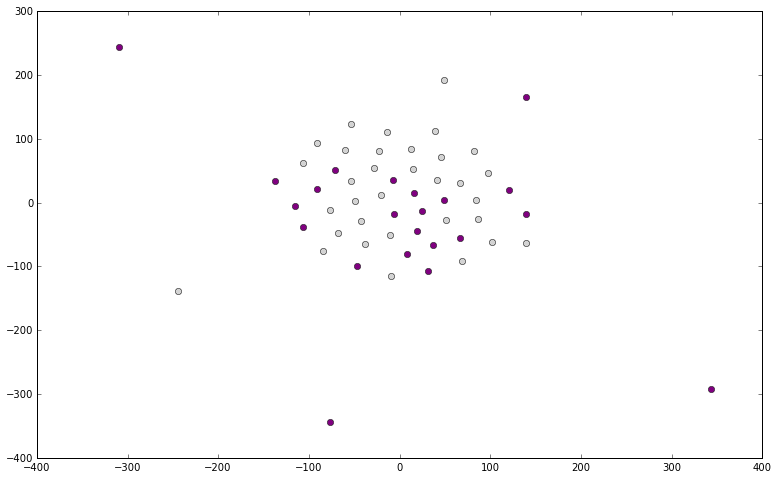

Average loss at step 200: 1.4
Test loss at step 200: 2.2
Average loss at step 400: 1.4
Test loss at step 400: 2.2
Average loss at step 600: 1.4
Test loss at step 600: 2.2
Average loss at step 800: 1.4
Test loss at step 800: 2.2
Average loss at step 1000: 1.4
Test loss at step 1000: 2.2
Average loss at step 1200: 1.4
Test loss at step 1200: 2.2
Average loss at step 1400: 1.4
Test loss at step 1400: 2.2
Average loss at step 1600: 1.4
Test loss at step 1600: 2.2
Average loss at step 1800: 1.4
Test loss at step 1800: 2.1
Average loss at step 2000: 1.4
Test loss at step 2000: 2.1
Average loss at step 2200: 1.4
Test loss at step 2200: 2.1
Average loss at step 2400: 1.4
Test loss at step 2400: 2.1
Average loss at step 2600: 1.4
Test loss at step 2600: 2.1
Average loss at step 2800: 1.3
Test loss at step 2800: 2.1
Most common class in sampled documents: earn


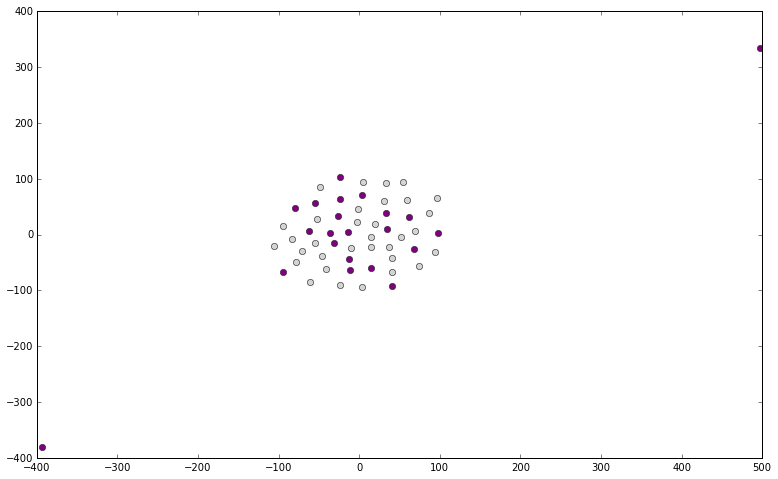

Average loss at step 200: 1.4
Test loss at step 200: 2.1
Average loss at step 400: 1.4
Test loss at step 400: 2.1
Average loss at step 600: 1.4
Test loss at step 600: 2.1
Average loss at step 800: 1.4
Test loss at step 800: 2.1
Average loss at step 1000: 1.4
Test loss at step 1000: 2.1
Average loss at step 1200: 1.3
Test loss at step 1200: 2.1
Average loss at step 1400: 1.3
Test loss at step 1400: 2.1
Average loss at step 1600: 1.4
Test loss at step 1600: 2.1
Average loss at step 1800: 1.3
Test loss at step 1800: 2.1
Average loss at step 2000: 1.4
Test loss at step 2000: 2.1
Average loss at step 2200: 1.4
Test loss at step 2200: 2.1
Average loss at step 2400: 1.4
Test loss at step 2400: 2.1
Average loss at step 2600: 1.4
Test loss at step 2600: 2.1
Average loss at step 2800: 1.4
Test loss at step 2800: 2.1
Most common class in sampled documents: earn


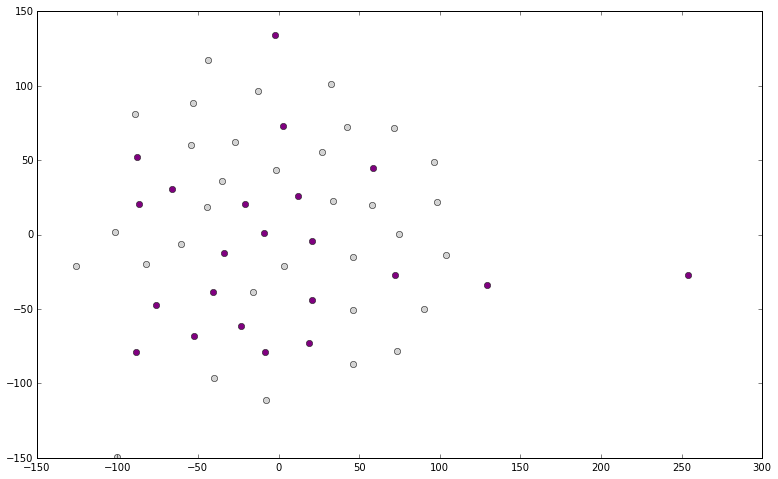

Average loss at step 200: 1.4
Test loss at step 200: 2.1
Average loss at step 400: 1.4
Test loss at step 400: 2.1
Average loss at step 600: 1.4
Test loss at step 600: 2.1
Average loss at step 800: 1.4
Test loss at step 800: 2.1
Average loss at step 1000: 1.4
Test loss at step 1000: 2.1
Most common class in sampled documents: earn


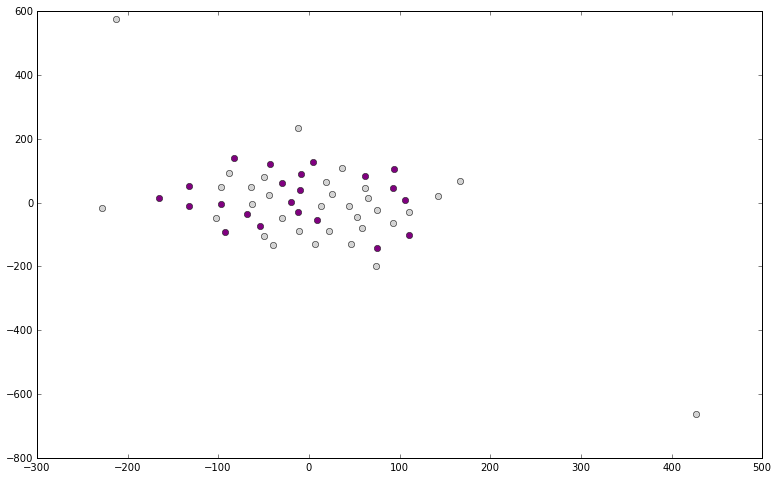

In [27]:
%lprun -f train run()